In [1]:
from __future__ import annotations

import os

import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from IPython.display import display
from sklearn.model_selection import GroupShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer

%config InlineBackend.figure_format = 'svg' 

In [2]:
RAW_DATA_FILENAME = 'reddit_ell_eng_raw_pos{}.csv'
RAW_DATA_MAXLEN = ['none', '300', '200']

In [3]:
def load_data(maxlen: str = 'none') -> pd.DataFrame:
    """Load the raw data from a csv file."""
    maxlen = f"_{maxlen}" if maxlen != "none" else ""
    df = pd.read_csv(f'{RAW_DATA_FILENAME.format(maxlen)}')
    return df


def group_shuffle_split(
    df: pd.DataFrame,
    *,
    groups: pd.Series,
    n_splits: int = 10,
    test_size: float = 0.2,
    random_state: int = 42,
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Perform a group shuffle split on a dataframe."""
    gss = GroupShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)
    train_idx, test_idx = next(gss.split(df, groups=groups))
    train_df = df.iloc[train_idx]
    test_df = df.iloc[test_idx]
    return train_df, test_df


def tfidf_features(
    df: pd.DataFrame,
    *,
    X: pd.Series | None = None,
    y: pd.Series | None = None,
    maxlen='none', 
    ngram_range=(1, 1), 
    max_features: int | None = None, 
    min_df=1, 
    max_df=1.0
) -> pd.DataFrame:
    """Extract TF-IDF features from a dataframe of text and labels."""

    X = df['text']
    y = df['label']

    vectorizer = TfidfVectorizer(
        ngram_range=ngram_range,
        max_features=max_features,
        min_df=min_df,
        max_df=max_df
    )

    X = vectorizer.fit_transform(X)

    features = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

    df = pd.concat([features, y], axis=1)

    n_grams = f'{ngram_range[0]}-{ngram_range[1]}' \
              if ngram_range[0] != ngram_range[1] else ngram_range[0]

    # df.to_csv(f'data/tfidf_features_{maxlen}_{ngram_range[0]}_{ngram_range[1]}_ngram_range.csv', index=False)

    return df


def plot_tfidf_features(
    df: pd.DataFrame, 
    *,
    ngram_range: tuple[int, int] = (1, 1)
) -> None:
    """Plot the TF-IDF features of a dataframe."""
    n_grams = f'{ngram_range[0]}-{ngram_range[1]}' \
              if ngram_range[0] != ngram_range[1] else ngram_range[0]
    df = df.drop('label', axis=1)
    df = df.sum().sort_values(ascending=False)
    df = df.head(20)
    df.plot.barh(zorder=3, color='C0')
    plt.title(f'Top 20 {n_grams} n-grams')
    plt.xlabel('TF-IDF')
    plt.ylabel('N-gram')
    plt.tight_layout()
    plt.grid(alpha=0.5, zorder=0)

    if not os.path.exists('figures'):
        os.makedirs('figures')
    plt.savefig(f'figures/tfidf_features_{n_grams}_ngrams.svg')

    plt.show()

maxlen='none'


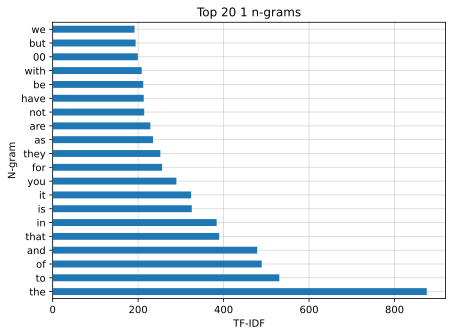

maxlen='300'


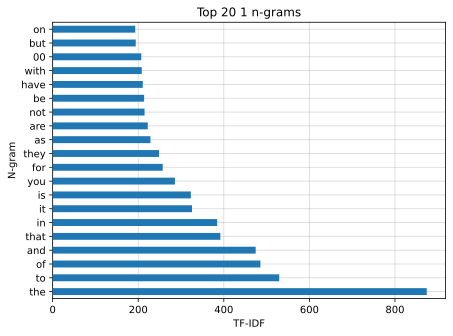

maxlen='200'


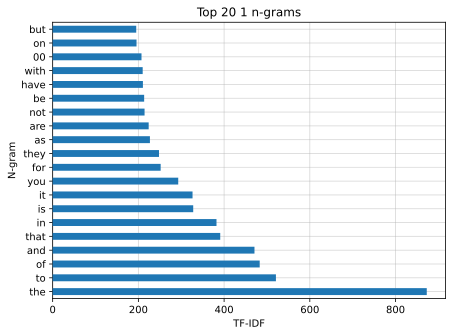

In [4]:
for maxlen in RAW_DATA_MAXLEN:
    df = load_data(maxlen)
    tf_idf = tfidf_features(df, ngram_range=(1, 1))
    print(f"{maxlen=}")
    plot_tfidf_features(tf_idf, ngram_range=(1, 1))

In [5]:
train_df, test_df = group_shuffle_split(df, groups=df['user_id'])

X = train_df['text']
y = train_df['label']

In [6]:
comb_df = pd.concat([train_df, test_df], axis=0)
comb_df.shape[0]

9888

## On the texts

In [7]:
vect = TfidfVectorizer(ngram_range=(1, 1))
X = vect.fit_transform(comb_df['text'])

In [8]:
dict(comb_df.groupby('label').groups.items())

{'ELL': Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
             ...
             4930, 4931, 4932, 4933, 4934, 4935, 4936, 4937, 4938, 4939],
            dtype='int64', length=4944),
 'ENG': Int64Index([4944, 4945, 4946, 4947, 4948, 4949, 4950, 4951, 4952, 4953,
             ...
             9754, 9785, 9786, 9787, 9789, 9790, 9792, 9793, 9861, 9863],
            dtype='int64', length=4944)}

In [9]:
X.shape

(9888, 27903)

In [12]:
# sum each tokens' TF-IDF value grouped by L1
grouped = {l1: X[lang_index, :].sum(axis=0).tolist()[0] 
           for l1, lang_index in comb_df.groupby('label').groups.items()}

# convert grouped dictionary into a df using the vect tokens as index
grouped = pd.DataFrame(grouped, index=vect.get_feature_names_out())
# drop tokens that are not present in both L1
grouped = grouped.dropna()
# drop tokens that have a frequency of 0 in one of the L1
grouped = grouped[(grouped['ELL'] != 0) & (grouped['ENG'] != 0)]
# drop tokens that do not contain at least 2 alphabetic characters
grouped = grouped[grouped.index.str.contains(r'[a-zA-Z]{2,}')]
# add a column with the difference between the two L1
grouped['diff'] = grouped.apply(lambda row: row[1] - row[0], axis=1)

fig, ax = plt.subplots()
cmap = mpl.colors.LinearSegmentedColormap.from_list('', ['#a52040', '#404080'])

# prepare tokens that will be added in the plot (L1 representation tokens)
annotations = grouped.loc[abs(grouped['diff']) > 19.5].reset_index()

annotations.apply(lambda row: ax.text(row['ELL'], row['ENG'], row['index']), axis=1)
ax.scatter(grouped['ELL'], grouped['ENG'], s=1, alpha=0.5, c=grouped['diff'], cmap=cmap, zorder=3)
ax.set_xlabel('Tokens usage frequency (Greek L1)')
ax.set_ylabel('Tokens usage frequency (English L1)')
ax.set_xlim(0, 175)
ax.set_ylim(0, 200)
ax.grid(alpha=0.5, zorder=0)

z = np.polyfit(grouped['ELL'], grouped['ENG'], 1)
p = np.poly1d(z)
plt.plot(grouped['ELL'], p(grouped['ELL']), '--', color='gold', zorder=2, alpha=0.5)

plt.show()

## On PoS tags

In [13]:
vect = TfidfVectorizer(ngram_range=(1, 1))
X = vect.fit_transform(comb_df['pos_tags'])

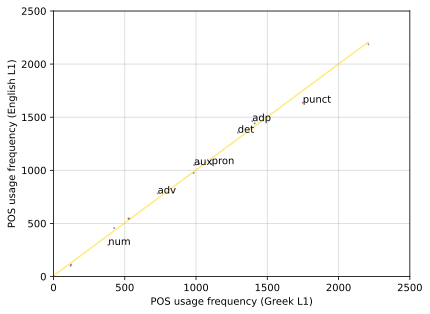

In [24]:
# sum each POS' TF-IDF value grouped by L1
grouped = {l1: X[lang_index, :].sum(axis=0).tolist()[0] 
           for l1, lang_index in comb_df.groupby('label').groups.items()}

# convert grouped dictionary into a df using the vect POS as index
grouped = pd.DataFrame(grouped, index=vect.get_feature_names_out())
# add a column with the difference between the two L1
grouped['diff'] = grouped.apply(lambda row: row[1] - row[0], axis=1)

fig, ax = plt.subplots()
cmap = mpl.colors.LinearSegmentedColormap.from_list('', ['#a52040', '#404080'])

# prepare POS that will be added in the plot (L1 representation POS)
annotations = grouped.loc[abs(grouped['diff']) > 50].reset_index()

annotations.apply(lambda row: ax.text(row['ELL'], row['ENG'], row['index']), axis=1)
ax.scatter(grouped['ELL'], grouped['ENG'], s=1, alpha=0.5, c=grouped['diff'], cmap=cmap, zorder=3)
ax.set_xlabel('POS usage frequency (Greek L1)')
ax.set_ylabel('POS usage frequency (English L1)')
ax.grid(alpha=0.5, zorder=0)
ax.set_xlim(0, 2500)
ax.set_ylim(0, 2500)

z = np.polyfit(grouped['ELL'], grouped['ENG'], 1)
p = np.poly1d(z)
plt.plot(grouped['ELL'], p(grouped['ELL']), '--', color='gold', zorder=2, alpha=0.5)

plt.show()